In [1]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#pip install --upgrade peft

In [3]:
pip install bert-score

Note: you may need to restart the kernel to use updated packages.


In [4]:
#pip install sentencepiece

In [5]:
# Load peft config for pre-trained checkpoint etc.
#peft_model_id = "results"
config = PeftConfig.from_pretrained("M2L_LR_S2_EXT4_EXP16_model")

# load base LLM model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, "M2L_LR_S2_EXT4_EXP16_model", use_dora = False, device_map='mps:0').to("mps")
model.eval()

print("Peft model loaded")

/Users/nevidujayatilleke/Documents/FYP-Abstractive Text Summarization/.venv/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Peft model loaded


In [6]:
from datasets import load_from_disk, DatasetDict
from random import randrange


# Load dataset from the hub and get a sample
#dataset = load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank')
dataset = DatasetDict({
    'train': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_3/train'),
    'validation': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_3/validation'),
    'test': load_from_disk('../../Data/Textile_Patent_(70-20-10)_LexRank_thres_3/test')
})
sample = dataset['test'][randrange(len(dataset["test"])-300)]


In [7]:
input_ids = tokenizer(sample["description"], return_tensors="pt", truncation=True).input_ids.to("mps")
# with torch.inference_mode():
outputs = model.generate(input_ids=input_ids, max_new_tokens=512, do_sample=True, top_p=0.9)
print(f"input sentence: {sample['description']}\n{'---'* 20}")

print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0])

input sentence: no . no . no . no . no . at this point , as shown in fig . thus , as shown in fig . as shown in fig . as shown in fig . in the position shown in fig . 3 , and a position raised out of and over the basket 78 , as shown in fig . within the extractor 26 , as shown in fig . 1 to the position raised over the drum , shown in fig . more particularly , as shown in figs . 1 . 3 . finally , as shown in figs . 8 . 7 . 7 . 4 . 5 . 2 . 2 . 9 . 12 . 3 and fig . 3 to the position shown in fig . nos . 4 to the position shown in fig . referring now to fig . with the laundry transfer apparatus 24 in the position shown in fig . for example , u.s. pat . when a third laundry batch 28c is located on the transfer apparatus 24 , as shown in fig . 1 , includes a washing machine 22 , a laundry transfer apparatus 24 and a centrifugal extractor 26 . the carrier 80 then raises from the position shown in fig . with the cam 134b in its third position , the conveyor belt motor 126b is operated by the 

In [8]:
outputs

tensor([[    2,     0,   250,  5448,     8, 26529,    13,  5774, 16937,    11,
            10, 40564, 39029, 14660,   368,    16,  1286,     4,    20, 26529,
          1171,    10, 14784,  3563,     6,    10, 16937,  2937, 26529,     6,
             8,    41, 14660,   368,     4,    20, 14784,  3563, 12291,     5,
         16937,    31,     5, 14784,  3563,     7,     5,  2937, 26529,     4,
            20,  2937, 26529,  1171,    41, 12210,  7494, 15451,   368, 13296,
            15,    10,   323,  5120,     4,    20, 14660,   368,  1171,    10,
         13351, 18564,     6, 40564, 39029, 12638, 13296,    15,     5,   323,
          5120,     6,     8,    10, 43285,     9,   740,  7042, 19470, 10481,
          3665,     7,     5, 15451,   368,  7494,     4,    20,   740,  7042,
           797,     5,  2079,     9,     5, 26529,   227,     5,  2452,  2343,
            11, 37365,     4,   112,     4,     8, 37365,     4,   132,     4,
             2]], device='mps:0')

In [9]:
import evaluate
import numpy as np
from datasets import load_from_disk
from tqdm import tqdm

# Metric
metric = evaluate.load("rouge")

def evaluate_peft_model(sample,max_target_length=512):
    # generate summary
    outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).to("mps"), do_sample=True, top_p=0.9, max_new_tokens=max_target_length)
    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(), skip_special_tokens=True)
    # decode eval sample
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(sample['labels'] != -100, sample['labels'], tokenizer.pad_token_id)
    labels = tokenizer.decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    return prediction, labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
# load test dataset from distk
test_dataset = load_from_disk("./tokenized_data_S2_EXT4_M2L/test").with_format("torch")

# run predictions
# this can take ~45 minutes
predictions, references = [] , []
for sample in tqdm(test_dataset):
    p,l = evaluate_peft_model(sample)
    predictions.append(p)
    references.append(l)

# compute metric
rogue = metric.compute(predictions=predictions, references=references, use_stemmer=True)

# print results
print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

# Rogue1: 50.386161%
# rouge2: 24.842412%
# rougeL: 41.370130%
# rougeLsum: 41.394230%

100%|██████████| 2259/2259 [7:01:15<00:00, 11.19s/it]   


Rogue1: 46.437346%
rouge2: 21.930581%
rougeL: 32.040169%
rougeLsum: 32.182737%


In [11]:
# Extracting Rouge scores
rouge1_score = rogue['rouge1'] * 100
rouge2_score = rogue['rouge2'] * 100
rougeL_score = rogue['rougeL'] * 100
rougeLsum_score = rogue['rougeLsum'] * 100

# Plotting the Rouge scores
labels = ['Rouge-1', 'Rouge-2', 'Rouge-L', 'Rouge-Lsum']
scores = [rouge1_score, rouge2_score, rougeL_score, rougeLsum_score]

(0.0, 100.0)

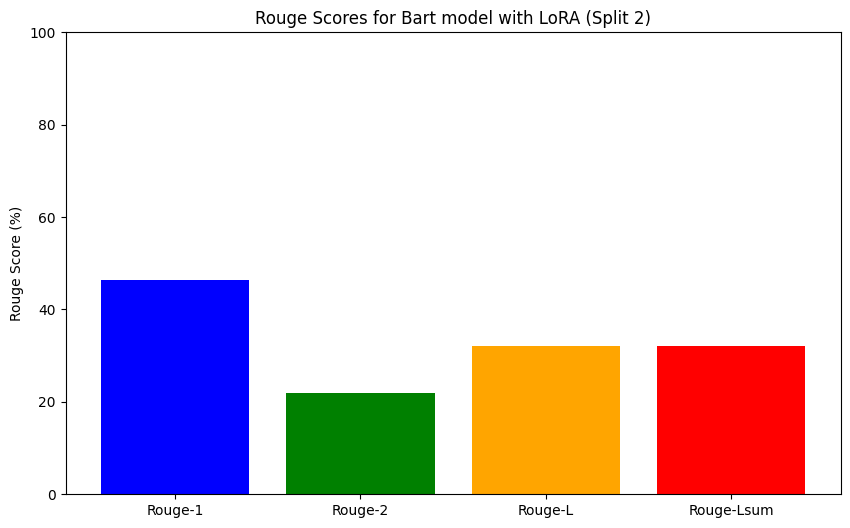

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Rouge Score (%)')
plt.title('Rouge Scores for Bart model with LoRA (Split 2)')
plt.ylim(0, 100)

In [13]:
from evaluate import load
bertscore = load("bertscore")

In [14]:
results = bertscore.compute(predictions=predictions, references=references, lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
#results['precision']
average_precision = sum(results['precision']) / len(results['precision'])
average_recall = sum(results['recall']) / len(results['recall'])
average_f1 = sum(results['f1']) / len(results['f1'])


In [16]:
print(f"Precision: {average_precision}")
print(f"Recall: {average_recall}")
print(f"F1: {average_f1}")

Precision: 0.8751991085111172
Recall: 0.8670980976766693
F1: 0.8708609987170678


In [17]:
meteor = load('meteor')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nevidujayatilleke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nevidujayatilleke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nevidujayatilleke/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
meteor_results = meteor.compute(predictions=predictions, references=references)

In [19]:
meteor_results['meteor']

0.3053649062890501